# Predicción del Precio de Bitcoin

En este notebook, vamos a realizar un análisis y predicción del precio de Bitcoin utilizando un modelo de Random Forest. A continuación, se detallan los pasos que seguiremos:

1. **Importación de Librerías**: Importaremos las librerías necesarias para el análisis y la predicción.
2. **Carga de Datos**: Cargaremos el dataset de precios históricos de Bitcoin.
3. **Preprocesamiento de Datos**: Realizaremos la limpieza y transformación de los datos, incluyendo la conversión de fechas y la creación de nuevas características.
4. **División de Datos**: Dividiremos los datos en conjuntos de entrenamiento y prueba.
5. **Entrenamiento del Modelo**: Entrenaremos un modelo de Random Forest utilizando una búsqueda de cuadrícula para encontrar los mejores hiperparámetros.
6. **Evaluación del Modelo**: Evaluaremos el rendimiento del modelo utilizando métricas como el MSE y el RMSE.
7. **Predicción para el Día Siguiente**: Realizaremos una predicción del precio de Bitcoin para el día siguiente.
8. **Visualización de Resultados**: Graficaremos los resultados obtenidos para una mejor interpretación.

Este análisis nos permitirá entender mejor el comportamiento del precio de Bitcoin y realizar predicciones basadas en datos históricos.

## Importación de Librerías

En esta sección, importamos las librerías necesarias para el análisis y la predicción del precio de Bitcoin. Utilizaremos pandas para la manipulación de datos, matplotlib para la visualización, y scikit-learn para el modelado y evaluación del modelo de Random Forest.

Las librerías importadas son:
- pandas
- matplotlib.pyplot
- sklearn.ensemble.RandomForestRegressor
- sklearn.model_selection.train_test_split
- sklearn.model_selection.GridSearchCV
- sklearn.metrics.mean_squared_error
- sklearn.model_selection.TimeSeriesSplit
- warnings

In [14]:
# Importar librerías necesarias
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import TimeSeriesSplit
import warnings
warnings.filterwarnings('ignore')

## Carga de Datos

En esta sección, cargamos el dataset de precios históricos de Bitcoin. Utilizamos la función `read_csv` de pandas para leer el archivo CSV que contiene los datos. A continuación, mostramos un resumen de la estructura del dataframe cargado.

In [25]:
# Cargar datos
df = pd.read_csv('bitcoin.csv', delimiter=',')

## Limpieza y Preprocesamiento de Datos

En esta sección, convertimos las fechas a un formato adecuado, limpiamos los valores numéricos y calculamos nuevas características para el modelo. A continuación, se detallan los pasos realizados:

1. **Conversión de Fechas**: Las fechas se convierten al formato `datetime` y se ordenan cronológicamente.
2. **Limpieza de Columnas Numéricas**: Se reemplazan los puntos por comas y se eliminan los separadores de miles para convertir las columnas numéricas a tipo `float`.
3. **Limpieza y Conversión de la Columna de Volumen**: Se convierten los valores de volumen en 'K', 'M', 'B' a valores numéricos.
4. **Creación de Nuevas Características**: Se crean nuevas características como el rango (diferencia entre el máximo y el mínimo) y el cambio (diferencia entre el último y la apertura).
5. **Conversión de Fechas a Número Ordinal**: Las fechas se convierten a números ordinales para ser utilizadas como características en el modelo.

Estas transformaciones son esenciales para preparar los datos antes de entrenar el modelo de predicción.

In [16]:
# Convertir fecha a formato datetime y ordenar por fecha
df['Fecha'] = pd.to_datetime(df['Fecha'], format='%d.%m.%Y', errors='coerce')
df = df.sort_values(by='Fecha')

# Limpieza de columnas numéricas
for col in ['Último', 'Apertura', 'Máximo', 'Mínimo']:
    df[col] = df[col].str.replace('.', '', regex=False).str.replace(',', '.', regex=False).astype(float)

# Limpieza y conversión de la columna de Volumen
df['Vol.'] = (
    df['Vol.']
    .str.replace('K', '*1e3', regex=False)  # Miles
    .str.replace('M', '*1e6', regex=False)  # Millones
    .str.replace('B', '*1e9', regex=False)  # Miles de millones
    .str.replace('.', '', regex=False)  # Eliminar puntos
    .str.replace(',', '.', regex=False)  # Reemplazar comas por puntos
    .map(eval)  # Evaluar las expresiones matemáticas
)

# Crear nuevas características
df['Rango'] = df['Máximo'] - df['Mínimo']
df['Cambio'] = df['Último'] - df['Apertura']
df['Fecha_ordinal'] = df['Fecha'].map(pd.Timestamp.toordinal)

In [17]:
df.tail()

,Fecha,Último,Apertura,Máximo,Mínimo,Vol.,% var.,Rango,Cambio,Fecha_ordinal
4,2025-01-06,102248.7,98373.2,102474.5,97932.3,86730.0,+3.97%,4542.2,3875.5,739257
3,2025-01-07,96929.8,102247.9,102678.2,96201.3,99770.0,-5.20%,6476.9,-5318.1,739258
2,2025-01-08,95066.6,96938.2,97266.4,92716.6,100360.0,-1.92%,4549.8,-1871.6,739259
1,2025-01-09,92539.8,95066.6,95323.1,91241.9,132780.0,-2.66%,4081.2,-2526.8,739260
0,2025-01-10,94724.1,92540.5,95760.6,92310.6,125420.0,+2.36%,3450.0,2183.6,739261


In [28]:
# Verificar valores nulos
valores_nulos = df.isnull().sum()
print("Valores nulos por columna:")
print(valores_nulos)

# Verificar duplicados
duplicados = df.duplicated()
df_duplicados = df[duplicados]
print(f"Total de filas duplicadas: {duplicados.sum()}")

Valores nulos por columna:
Fecha       0
Último      0
Apertura    0
Máximo      0
Mínimo      0
Vol.        0
% var.      0
dtype: int64
Total de filas duplicadas: 0


## Selección de características y división de los datos

En esta sección, creamos las variables independientes (X) y la dependiente (y). Luego, dividimos los datos en conjuntos de entrenamiento y prueba.

### Variables Independientes (X)
Las variables independientes seleccionadas son:
- `Fecha_ordinal`: La fecha convertida a un número ordinal.
- `Apertura`: El precio de apertura del Bitcoin.
- `Máximo`: El precio máximo del Bitcoin en el día.
- `Mínimo`: El precio mínimo del Bitcoin en el día.
- `Vol.`: El volumen de transacciones del Bitcoin.
- `Rango`: La diferencia entre el precio máximo y mínimo del día.
- `Cambio`: La diferencia entre el precio de cierre y el de apertura del día.

### Variable Dependiente (y)
La variable dependiente es:
- `Último`: El precio de cierre del Bitcoin.

### División de los Datos
Dividimos los datos en conjuntos de entrenamiento y prueba utilizando una proporción de 80% para entrenamiento y 20% para prueba. Esto nos permite entrenar el modelo con la mayoría de los datos y evaluar su rendimiento con un conjunto de datos no vistos durante el entrenamiento.


In [18]:
# Crear las variables independientes y dependiente
X = df[['Fecha_ordinal', 'Apertura', 'Máximo', 'Mínimo', 'Vol.', 'Rango', 'Cambio']]
y = df['Último']

# Dividir los datos en entrenamiento (80%) y prueba (20%)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=44)

# Verificar las dimensiones de los conjuntos
print(f"Dimensiones de X_train: {X_train.shape}, X_test: {X_test.shape}")
print(f"Dimensiones de y_train: {y_train.shape}, y_test: {y_test.shape}")

Dimensiones de X_train: (3798, 7), X_test: (950, 7)
Dimensiones de y_train: (3798,), y_test: (950,)


## Ajuste del Modelo Random Forest con GridSearchCV

En esta sección, ajustamos los hiperparámetros del modelo Random Forest utilizando GridSearchCV con validación cruzada.

### Explicación

- **GridSearchCV**: Utilizamos GridSearchCV para realizar una búsqueda exhaustiva sobre un conjunto de hiperparámetros especificados. Esto nos permite encontrar la mejor combinación de hiperparámetros para nuestro modelo.
- **RandomForestRegressor**: El modelo de Random Forest que estamos ajustando.
- **TimeSeriesSplit**: Utilizamos TimeSeriesSplit para realizar la validación cruzada, ya que estamos trabajando con datos de series temporales.
- **Parámetros**: Definimos una cuadrícula de hiperparámetros (`param_grid`) que incluye el número de estimadores, la profundidad máxima de los árboles, el número mínimo de muestras para dividir un nodo, el número mínimo de muestras en una hoja y el número de características a considerar para la mejor división.

### Código

In [19]:
# Definición del grid de hiperparámetros
param_grid = {
    'n_estimators': [100, 200, 300, 400],
    'max_depth': [10, 15, 20, 30],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4],
    'max_features': ['sqrt', 'log2']
}

# Configuración de la validación cruzada para series temporales
tscv = TimeSeriesSplit(n_splits=5)

# Ajustar el modelo con GridSearchCV
grid_search = GridSearchCV(
    estimator=RandomForestRegressor(random_state=44),
    param_grid=param_grid,
    cv=tscv,
    n_jobs=-1,
    verbose=2
)
grid_search.fit(X_train, y_train)

# Guardar el mejor modelo encontrado
best_model = grid_search.best_estimator_
print("Mejores hiperparámetros:", grid_search.best_params_)

Fitting 5 folds for each of 288 candidates, totalling 1440 fits
[CV] END max_depth=10, max_features=sqrt, min_samples_leaf=1, min_samples_split=2, n_estimators=100; total time=   0.4s
[CV] END max_depth=10, max_features=sqrt, min_samples_leaf=1, min_samples_split=2, n_estimators=100; total time=   0.5s
[CV] END max_depth=10, max_features=sqrt, min_samples_leaf=1, min_samples_split=2, n_estimators=100; total time=   0.6s
[CV] END max_depth=10, max_features=sqrt, min_samples_leaf=1, min_samples_split=2, n_estimators=200; total time=   0.8s
[CV] END max_depth=10, max_features=sqrt, min_samples_leaf=1, min_samples_split=2, n_estimators=100; total time=   0.9s
[CV] END max_depth=10, max_features=sqrt, min_samples_leaf=1, min_samples_split=2, n_estimators=300; total time=   0.9s
[CV] END max_depth=10, max_features=sqrt, min_samples_leaf=1, min_samples_split=2, n_estimators=100; total time=   1.0s
[CV] END max_depth=10, max_features=sqrt, min_samples_leaf=1, min_samples_split=2, n_estimators=

## Evaluación del Modelo

En esta sección, evaluamos el modelo ajustado en el conjunto de prueba y calculamos las métricas MSE y RMSE.

### Explicación

- **MSE (Mean Squared Error)**: El error cuadrático medio es una métrica que mide el promedio de los errores al cuadrado. Es útil para entender la magnitud de los errores de predicción.
- **RMSE (Root Mean Squared Error)**: La raíz del error cuadrático medio es la raíz cuadrada del MSE. Proporciona una medida de error en las mismas unidades que la variable objetivo, lo que facilita su interpretación.

### Código


In [20]:
# Evaluar el modelo en el conjunto de prueba
y_pred_rf = best_model.predict(X_test)
mse_rf = mean_squared_error(y_test, y_pred_rf)
rmse_rf = mse_rf ** 0.5

print(f"Error cuadrático medio (MSE): {mse_rf}")
print(f"Raíz del error cuadrático medio (RMSE): {rmse_rf}")

Error cuadrático medio (MSE): 87239.16187855897
Raíz del error cuadrático medio (RMSE): 295.36276318886064


## Predicción del Precio del Siguiente Día

### Explicación

En esta sección, realizamos una predicción para el siguiente día utilizando los datos más recientes del dataset. Utilizamos el modelo de Random Forest ajustado previamente para predecir el precio de cierre del Bitcoin para el día siguiente.

### Código


In [21]:
# Predicción para el siguiente día
proxima_fecha = df['Fecha'].max() + pd.Timedelta(days=1)
proxima_fecha_ordinal = proxima_fecha.toordinal()
entrada_prediccion = pd.DataFrame({
    'Fecha_ordinal': [proxima_fecha_ordinal],
    'Apertura': [df['Apertura'].iloc[-1]],
    'Máximo': [df['Máximo'].iloc[-1]],
    'Mínimo': [df['Mínimo'].iloc[-1]],
    'Vol.': [df['Vol.'].iloc[-1]],
    'Rango': [df['Rango'].iloc[-1]],
    'Cambio': [df['Cambio'].iloc[-1]]
})

precio_predicho_rf = best_model.predict(entrada_prediccion)[0]
print(f"El precio predicho del Bitcoin para el día {proxima_fecha.date()} es: {precio_predicho_rf:.2f}")

El precio predicho del Bitcoin para el día 2025-01-11 es: 94855.54


## Visualización de Resultados

### Explicación

En esta sección, creamos gráficos para comparar los datos reales con las predicciones del modelo y marcamos el valor predicho para el siguiente día. Esto nos permite visualizar el rendimiento del modelo y evaluar la precisión de las predicciones.

### Código


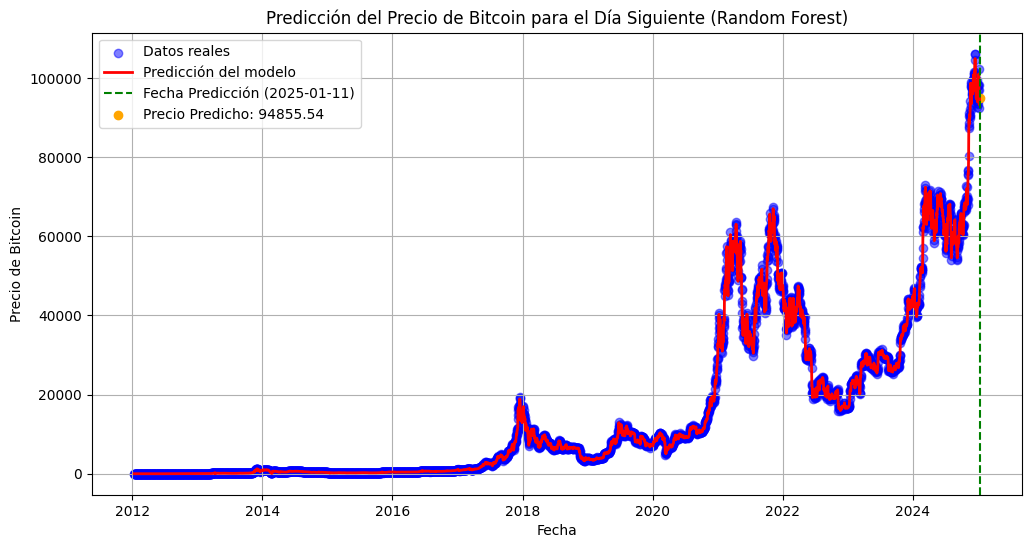

In [22]:
# Gráfica de resultados
plt.figure(figsize=(12, 6))

# Gráfica de los datos reales
plt.scatter(df['Fecha'], df['Último'], color='blue', label='Datos reales', alpha=0.5)

# Gráfica de las predicciones del modelo sobre los datos históricos
predicciones_historicas_rf = best_model.predict(X)
plt.plot(df['Fecha'], predicciones_historicas_rf, color='red', label='Predicción del modelo', linewidth=2)

# Punto para la predicción del día siguiente
plt.axvline(x=proxima_fecha, color='green', linestyle='--', label=f'Fecha Predicción ({proxima_fecha.date()})')
plt.scatter(proxima_fecha, precio_predicho_rf, color='orange', label=f'Precio Predicho: {precio_predicho_rf:.2f}')

# Etiquetas y título
plt.xlabel('Fecha')
plt.ylabel('Precio de Bitcoin')
plt.title('Predicción del Precio de Bitcoin para el Día Siguiente (Random Forest)')
plt.legend()
plt.grid()
plt.show()

## Evaluación Adicional del Modelo

Esta sección nos ayuda a:

- **Verificar la consistencia del modelo con validación cruzada**: Utilizamos la métrica de MSE promedio en múltiples divisiones del dataset para evaluar la estabilidad del modelo.
- **Evaluar la precisión de las predicciones del modelo**: Calculamos el MAE para entender el error promedio de las predicciones del modelo.

### Métricas de Evaluación

- **MSE (Mean Squared Error)**: El error cuadrático medio mide el promedio de los errores al cuadrado. Es útil para entender la magnitud de los errores de predicción.
- **MAE (Mean Absolute Error)**: El error absoluto medio mide el promedio de los errores absolutos. Es útil para entender la precisión de las predicciones del modelo.

Estas métricas complementan las evaluaciones anteriores, proporcionando una visión más completa del rendimiento del modelo.

In [23]:
from sklearn.model_selection import cross_val_score
from sklearn.metrics import mean_absolute_error

scores = cross_val_score(best_model, X, y, scoring='neg_mean_squared_error', cv=5)
print("MSE promedio:", -scores.mean())

mae_rf = mean_absolute_error(y_test, y_pred_rf)
print(f"Error absoluto medio (MAE): {mae_rf}")

MSE promedio: 26011144.65356604
Error absoluto medio (MAE): 146.9709309360296


## Verificación de Datos

Al final del proceso de modelado, utilizamos `df.info()` para verificar que todos los datos están correctamente cargados y que no hay ningún dato faltante. Esta función proporciona un resumen conciso del DataFrame, incluyendo el número de entradas, el nombre de las columnas, el tipo de datos de cada columna y el número de valores no nulos.

### Explicación

- **Número de Entradas**: Indica la cantidad total de filas en el DataFrame.
- **Nombre de las Columnas**: Lista los nombres de todas las columnas presentes en el DataFrame.
- **Tipo de Datos**: Muestra el tipo de datos de cada columna (por ejemplo, `int64`, `float64`, `datetime64[ns]`, etc.).
- **Valores No Nulos**: Indica cuántos valores no nulos hay en cada columna, lo que es útil para identificar columnas con datos faltantes.
- **Uso de Memoria**: Proporciona una estimación del uso de memoria del DataFrame.

Este paso es para asegurarnos de que los datos están en el formato correcto.

In [24]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 4748 entries, 4747 to 0
Data columns (total 10 columns):
 #   Column         Non-Null Count  Dtype         
---  ------         --------------  -----         
 0   Fecha          4748 non-null   datetime64[ns]
 1   Último         4748 non-null   float64       
 2   Apertura       4748 non-null   float64       
 3   Máximo         4748 non-null   float64       
 4   Mínimo         4748 non-null   float64       
 5   Vol.           4748 non-null   float64       
 6   % var.         4748 non-null   object        
 7   Rango          4748 non-null   float64       
 8   Cambio         4748 non-null   float64       
 9   Fecha_ordinal  4748 non-null   int64         
dtypes: datetime64[ns](1), float64(7), int64(1), object(1)
memory usage: 408.0+ KB
